# NBEATS Model Training

## 1. Setup Training Environment

In [ ]:
# Connect Google Colab to Google Drive
from google.colab import drive
import os

MOUNT_POINT = '/content/gdrive'
drive.mount(MOUNT_POINT)

DEFAULT_DIR = os.path.join(MOUNT_POINT, 'Shareddrives', 'Meta Learning Model Training')

In [ ]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.0 MB/s 
     |████████████████████████████████| 11.2 MB 62.5 MB/s 
     |████████████████████████████████| 76.8 MB 1.1 MB/s 
     |████████████████████████████████| 1.8 MB 71.9 MB/s 
     |████████████████████████████████| 708 kB 80.0 MB/s 
     |████████████████████████████████| 569 kB 91.3 MB/s 
     |████████████████████████████████| 43 kB 2.4 MB/s 
     |████████████████████████████████| 9.8 MB 62.3 MB/s 
     |████████████████████████████████| 77 kB 7.5 MB/s 
     |████████████████████████████████| 1.6 MB 77.1 MB/s 
     |████████████████████████████████| 960 kB 84.5 MB/s 
     |████████████████████████████████| 529 kB 88.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
  Attempting uninstall: matplotlib

In [ ]:
# Import Libraries
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from darts.models import NBEATSModel, NHiTSModel
from darts import TimeSeries
from darts.metrics import mape, r2_score, smape, ope, rmse
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts import concatenate

from torchmetrics import SymmetricMeanAbsolutePercentageError, MeanAbsolutePercentageError,MeanSquaredError
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

import matplotlib.pyplot as plt
from datetime import datetime
import pickle
import os

If there is an error regarding yaml, go to the /usr/local/lib/python3.7/dist-packages/distributed/config.py and change line 20 to 
```
defaults = yaml.load(f, Loader=yaml.SafeLoader)
```

In [ ]:
### Initialize parameters
# Paths
DATE_TODAY = datetime.today().strftime('%Y-%m-%d')
MOUNT_POINT = '/content/gdrive'
DEFAULT_DIR = os.path.join(MOUNT_POINT, 'Shareddrives', 'Meta Learning Model Training')
DATA_PATH = os.path.join(DEFAULT_DIR, "daily_stock_data")
COV_DATA_PATH = os.path.join(DEFAULT_DIR, "covariates_data")
SECTOR = "finance"
SECTOR_PATH = "sectors"
TICKER_PATH = os.path.join(DEFAULT_DIR, SECTOR_PATH, SECTOR + ".txt")
COV_TICKER_PATH = os.path.join(DEFAULT_DIR, 'cov_ticker.txt')
SAVE_DF_PATH = os.path.join(DEFAULT_DIR, "saved_dataframe")
TRAIN_MODEL_PATH = os.path.join(DEFAULT_DIR, "trained_models", DATE_TODAY)

# Model Parameters
MODEL = NBEATSModel
OUTPUT_CHUNK_LENGTH = 30  # Horizon (Forecast Period)
INPUT_CHUNK_LENGTH = OUTPUT_CHUNK_LENGTH * 5 # Lookback perio\d. In the paper, [1-7]*forecast_period (H) is being used
NUM_STACKS = 30
NUM_BLOCKS = 1 
NUM_LAYERS = 4
GENERIC = True # Generic or Interpretable
LAYER_WIDTHS = 512 if GENERIC else 256  # Adjust layer widths based on type of the model
BATCH_SIZE = 32
N_EPOCHS = 100
LOSS_FN = MeanSquaredError()

PL_TRAINER_KWARGS={"accelerator": "gpu", 
                   "gpus": [0],}

DARTS_DIR = os.path.join(DEFAULT_DIR, "darts_logs", DATE_TODAY)
# ENCODERS = {
#     "cyclic": {"past": ["month"]},
#     "datetime_attribute": {"past": ["dayofweek"]},
#     "position": {"past": ["absolute"]},
#     "transformer": Scaler(),
# }

# Preprocessing Parameters
# START_DATE = "2010-01-04"
# END_DATE = "2022-07-01"
START_DATE = "2019-01-02"
END_DATE = "2022-07-01"
SPLIT_VAL_DATE = "20210101"
SPLIT_TEST_DATE = "20220101"
METHOD = "logret" # method_list = ["logprice", "logret"]

In [ ]:
# Load tickers specified in text files
def load_tickers(ticker_path):
  
  with open(ticker_path) as f:
    tickers = [t.rstrip() for t in f if t.rstrip()]
  
  return tickers

# tickers = ['MSFT', 'GOOG', 'ADBE', 'INTU', 'ADP', 'SNPS', 'ANSS']

# Load coviarates tickers
with open(COV_TICKER_PATH) as f:
   cov_tickers = [t.rstrip() for t in f if t.rstrip()]

# Generate a list of business days
template = pd.DataFrame(pd.date_range(START_DATE, END_DATE, freq=BDay()), columns=['Datetime']).set_index("Datetime")

# Create a folder for current date to store checkpoints
if not os.path.isdir(DARTS_DIR):
  os.mkdir(DARTS_DIR)

# Create a folder for current date to trained models
if not os.path.isdir(TRAIN_MODEL_PATH):
  os.mkdir(TRAIN_MODEL_PATH)

<AxesSubplot:xlabel='Datetime'>

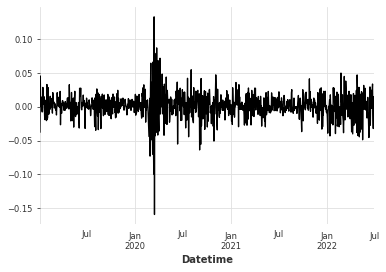

In [ ]:
tickers = ['MSFT']
template = pd.DataFrame(pd.date_range(START_DATE, END_DATE, freq=BDay()), columns=['Datetime']).set_index("Datetime")

for t in tickers:
    
    # Load data file
    file_path = os.path.join(DATA_PATH, "{}.csv".format(t))
    if not os.path.exists(file_path):
        continue
    df = pd.read_csv(file_path, index_col = 0, parse_dates = True)
    df = df["Close"]

    # Ensure datetime index is consistent
    df = pd.merge(template, df, left_index=True, right_index=True, how="left")
    df.fillna(method = "ffill", inplace = True) # Forward fill missing values
    df.fillna(method = "bfill", inplace = True) # Backward fill missing values
    
    df['log_return'] = (np.log(df["Close"]) - np.log(df["Close"].shift(1)))

df['log_return'].plot()

## 2. Data Preprocessing



In [ ]:
# Generate list of correlated tickers
THRESHOLD = 0.75
compile_df = template.copy()

for t in tickers:
    
    # Load data file
    file_path = os.path.join(DATA_PATH, "{}.csv".format(t))
    if not os.path.exists(file_path):
        continue
    df = pd.read_csv(file_path, index_col = 0, parse_dates = True)
    df = df["Close"]

    # Ensure datetime index is consistent
    df = pd.merge(template, df, left_index=True, right_index=True, how="left")
    df.fillna(method = "ffill", inplace = True) # Forward fill missing values
    df.fillna(method = "bfill", inplace = True) # Backward fill missing values

    if df.empty or np.isnan(df.iloc[0,0]):
        continue
    
    compile_df[t] = (np.log(df["Close"]) - np.log(df["Close"].shift(1)))

corr_compile_df = compile_df.corr() # Find the correlation between every stocks

# Create a hashmap to store count of each correlated ticker
corr_hm = {}

# Populate each ticker with initial value of 0
for t in tickers:
  corr_hm[t] = 0

# Count the number of correlated ticker
for i in range(len(corr_compile_df.columns)):
  corr_first_df = corr_compile_df[corr_compile_df.columns[i]]
  corr_filtered = corr_first_df[corr_first_df >= THRESHOLD]
  corr_filtered.sort_values(ascending = False, inplace = True)
  corr_filtered = corr_filtered[1:11] # Only select top 10, excluding itself

  # Update count in hashmap
  for index, value in corr_filtered.items():
    corr_hm[index] += 1

# Get the top 5 highest count
sorted_count = sorted(corr_hm.items(), key = lambda item: item[1], reverse = True)[:5]

# Get the final resulting tickers to be used to train the model
train_tickers = [item[0] for item in sorted_count]
print(train_tickers)

In [ ]:
# These are the stocks that will be used to train the model
train_tickers = ['MET', 'PRU', 'JPM', 'BAC', 'C']

In [ ]:
# Initialize variables to store dataframes
series = []
train_series = []
val_series = []
test_series = []

for t in train_tickers:

    # Load data file
    file_path = os.path.join(DATA_PATH, "{}.csv".format(t))
    if not os.path.exists(file_path):
      continue
    df = pd.read_csv(file_path, index_col = 0, parse_dates = True)
    
    # Ensure dataframe consists of all business days 
    df = pd.merge(template, df, left_index=True, right_index=True, how="left")
    if np.isnan(df.iloc[0,0]): # Ensure all datasets have same starting point
      continue

    # Fill missing values in TimeSeries
    df.fillna(method = 'ffill', inplace = True)
    df.fillna(method = 'bfill', inplace = True)

    # Calculate the log return of stock prices
    if METHOD == "logret":
      df["Close"] = (np.log(df["Close"]) - np.log(df["Close"].shift(1)))
      df = df[1:]
    else:
    # Calculate the log price
      df["Close"] = df["Close"].apply(np.log)

    df = df["Close"]

    data = TimeSeries.from_series(df, freq = 'B')
    series.append(data)

    # Split into train and test dataset
    train, val = data.split_before(pd.Timestamp(SPLIT_VAL_DATE)) # Train = 1/1/2010 - 31/12/2019, Val = 1/1/2020 - 31/12/2021, Test = 1/1/2022 - 1/7/2022
    val, test = val.split_before(pd.Timestamp(SPLIT_TEST_DATE))
    
    # Add series to list
    train_series.append(train)
    val_series.append(val)
    test_series.append(test)

In [ ]:
val_series[0]

<TimeSeries (DataArray) (Datetime: 260, component: 1, sample: 1)>
array([[[ 0.        ]],

       [[-0.01870417]],

       [[ 0.0122939 ]],

       [[ 0.05788457]],

       [[ 0.00303003]],

       [[-0.00343473]],

       [[-0.00020237]],

       [[ 0.01606459]],

       [[ 0.00258632]],

       [[ 0.02433874]],

...

       [[-0.01874437]],

       [[-0.02793854]],

       [[ 0.02909968]],

       [[ 0.00924101]],

       [[ 0.01467494]],

       [[ 0.        ]],

       [[ 0.0114269 ]],

       [[ 0.00191845]],

       [[ 0.0011174 ]],

       [[-0.00159665]]])
Coordinates:
  * Datetime   (Datetime) datetime64[ns] 2021-01-01 2021-01-04 ... 2021-12-30
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [ ]:
# Generate train, val, test from all tickers
TEST = False

# Initialize folder name for dataframes to be saved 
df_name = "{}_{}_{}_{}".format(SECTOR, METHOD, START_DATE, END_DATE)
df_path = os.path.join(SAVE_DF_PATH, df_name)

# Initialize variables to store dataframes
all_series = []
all_train_series = []
all_val_series = []
all_test_series = []

# Initialize saved dataframes paths
full_series_path = os.path.join(df_path, "full_series.pickle")
train_series_path = os.path.join(df_path, "train_series.pickle")
val_series_path = os.path.join(df_path, "val_series.pickle")
test_series_path = os.path.join(df_path, "test_series.pickle")

# Check if existing dataframes exists
if not TEST and os.path.isdir(df_path):

  with open(full_series_path, "rb") as handle:
    all_series = pickle.load(handle)
  
  with open(train_series_path, "rb") as handle:
    all_train_series = pickle.load(handle)

  with open(val_series_path, "rb") as handle:
    all_val_series = pickle.load(handle)

  with open(test_series_path, "rb") as handle:
    all_test_series = pickle.load(handle)

else:

  if not TEST:
    os.mkdir(df_path)

  for t in tickers:

      # Load data file
      file_path = os.path.join(DATA_PATH, "{}.csv".format(t))
      if not os.path.exists(file_path):
        continue
      df = pd.read_csv(file_path, index_col = 0, parse_dates = True)
      
      # Ensure dataframe consists of all business days 
      df = pd.merge(template, df, left_index=True, right_index=True, how="left")
      if np.isnan(df.iloc[0,0]): # Ensure all datasets have same starting point
        continue

      # Fill missing values in TimeSeries
      df.fillna(method = 'ffill', inplace = True)
      df.fillna(method = 'bfill', inplace = True)

      # Calculate the log return of stock prices
      if METHOD == "logret":
        df["Close"] = (np.log(df["Close"]) - np.log(df["Close"].shift(1)))
        df = df[1:]
      else:
      # Calculate the log price
        df["Close"] = df["Close"].apply(np.log)

      df = df["Close"]

      data = TimeSeries.from_series(df, freq = 'B')
      series.append(data)

      # Split into train and test dataset
      train, val = data.split_before(pd.Timestamp(SPLIT_VAL_DATE)) # Train = 1/1/2010 - 31/12/2019, Val = 1/1/2020 - 31/12/2021, Test = 1/1/2022 - 1/7/2022
      val, test = val.split_before(pd.Timestamp(SPLIT_TEST_DATE))
      
      # Add series to list
      all_train_series.append(train)
      all_val_series.append(val)
      all_test_series.append(test)

  # Save dataframes
  if not TEST:
    with open(os.path.join(df_path, "full_series.pickle"), "wb") as handle:
      pickle.dump(all_series, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(os.path.join(df_path, "train_series.pickle"), "wb") as handle:
      pickle.dump(all_train_series, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(os.path.join(df_path, "val_series.pickle"), "wb") as handle:
      pickle.dump(all_val_series, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(os.path.join(df_path, "test_series.pickle"), "wb") as handle:
      pickle.dump(all_test_series, handle, protocol=pickle.HIGHEST_PROTOCOL)


## 3. Model Training

In [ ]:
# Load existing model or create a new model
load = True

if load:
  logs_path = "/content/gdrive/Shareddrives/Meta Learning Model Training/darts_logs/2022-09-19"
  model_name = "2_NBEATSModel_finance_corr_5stocks_icl150_ocl30_gTrue_s30_b1_l4_lw512_bs32_e100_start2019-01-02_end2022-07-01"
  model = NBEATSModel.load_from_checkpoint(model_name = model_name, work_dir = logs_path, best = False)
else:
  model_name = "{}_{}_{}_{}_icl{}_ocl{}_g{}_s{}_b{}_l{}_lw{}_bs{}_e{}_start{}_end{}".format(
      len(os.listdir(DARTS_DIR)),
      ''.join(filter(str.isalnum,str(MODEL).split(".")[-1])), 
      input(),
      SECTOR,
      INPUT_CHUNK_LENGTH,
      OUTPUT_CHUNK_LENGTH,
      GENERIC,
      NUM_STACKS,
      NUM_BLOCKS,
      NUM_LAYERS,
      LAYER_WIDTHS,
      BATCH_SIZE,
      N_EPOCHS,
      START_DATE,
      END_DATE)
  
  model = NBEATSModel(input_chunk_length = INPUT_CHUNK_LENGTH,
                      output_chunk_length = OUTPUT_CHUNK_LENGTH,
                      generic_architecture = GENERIC,
                      num_stacks = NUM_STACKS,
                      num_blocks = NUM_BLOCKS,
                      num_layers = NUM_LAYERS,
                      layer_widths = LAYER_WIDTHS,
                      batch_size = BATCH_SIZE,
                      n_epochs = N_EPOCHS,
                      work_dir = DARTS_DIR,
                      pl_trainer_kwargs = PL_TRAINER_KWARGS,
                      model_name = model_name,
                      loss_fn = LOSS_FN,
                      log_tensorboard = True,
                      save_checkpoints = True,
                      force_reset = True)
  
### Load model from checkpoint
# logs_path = "/content/gdrive/Shareddrives/Meta Learning Model Training/darts_logs/"
# model_name = "2022-08-03_logret-5stocks"
# model = NBEATSModel.load_from_checkpoint(model_name = model_name, work_dir = logs_path, best = False)

### Load trained model
# model_path = "/content/gdrive/Shareddrives/Meta Learning Model Training/trained_models/2022-08-03-logprice-10stocks.pth.tar"
# model = NBEATSModel.load_model(model_path)

In [ ]:
# Train model
model.fit(series = train_series,
          val_series = val_series)

# Save trained model
saved_model_path = os.path.join(TRAIN_MODEL_PATH, model_name + ".pth.tar")
model.save(saved_model_path)

## 4. Model Evaluation

In [ ]:
# Zero-shot forecasting - Use the trained model to predict other stocks
# train_tickers = ['MET', 'PRU', 'JPM', 'BAC', 'C']
stocks_to_be_predicted = [tickers.index("HSBC")]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Predicting: 0it [00:00, ?it/s]

sMAPE: 57.84%:
Winning Score: 46.67%
RMSE (x1000): 21.87


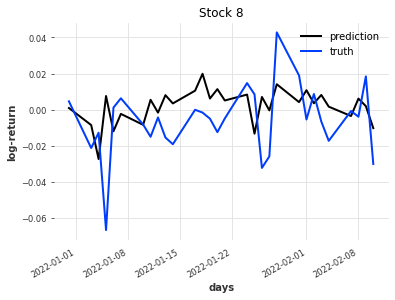

In [ ]:
# Evaluate the model
horizon = OUTPUT_CHUNK_LENGTH

for dataset in stocks_to_be_predicted:

  # Generate prediction
  pred = model.predict(series = all_val_series[dataset],
                       n = horizon)
  test = all_test_series[dataset][:horizon]

  # Generate sMAPE score
  smape_score = round(smape(test,pred), 2)


  # Calculate winning score
  winning_df = pd.merge(TimeSeries.pd_series(pred).to_frame(), TimeSeries.pd_series(test).to_frame(), left_index = True, right_index = True)
  winning_df.rename(columns = {"0_x": "pred_result", "0_y": "test_result"}, inplace = True)
  winning_df["pred_score"] = np.where(winning_df["pred_result"] < 0, 0, 1)
  winning_df["test_score"] = np.where(winning_df["test_result"] < 0, 0, 1)
  winning_df["same_score"] = np.where(winning_df["pred_score"] == winning_df["test_score"], True, False)
  winning_score = winning_df["same_score"].value_counts(normalize = True).mul(100).round(2)


  # Calculate RMSE
  rmse_score = rmse(test, pred) * 1000

  # Print results
  print("sMAPE: {}%:".format(smape_score - 100))
  print("Winning Score: {}%".format(winning_score[True].astype(str)))
  print("RMSE (x1000): {:.2f}".format(rmse_score))

  # Plot prediction
  plt.figure()
  pred.plot(label = "prediction")
  test.plot(label = "truth")
  plt.title('Stock {}'.format(dataset+1))
  plt.xlabel('days')
  plt.ylabel('log-return')

In [ ]:
PLOT = True

horizon = OUTPUT_CHUNK_LENGTH
len_train_series = len(all_train_series)
# len_train_series = len(train_series)
avg_winning_score = 0
avg_smape_score = 0
avg_rmse_score = 0

for dataset in range(len_train_series):
  pred = model.predict(series = all_val_series[dataset],
                       n = horizon)
  test = all_test_series[dataset][:horizon]
  smape_score = round(smape(test,pred), 2)
  avg_smape_score += smape_score

  print("sMAPE:", smape_score)

  # Calculate winning score
  if METHOD == 'logret':
    winning_df = pd.merge(TimeSeries.pd_series(pred).to_frame(), TimeSeries.pd_series(test).to_frame(), left_index = True, right_index = True)
    winning_df.rename(columns = {"0_x": "pred_result", "0_y": "test_result"}, inplace = True)
    winning_df["pred_score"] = np.where(winning_df["pred_result"] < 0, 0, 1)
    winning_df["test_score"] = np.where(winning_df["test_result"] < 0, 0, 1)
    winning_df["same_score"] = np.where(winning_df["pred_score"] == winning_df["test_score"], True, False)
    winning_score = winning_df["same_score"].value_counts(normalize = True).mul(100).round(2)
    avg_winning_score += winning_score[True]

    print("Winning Score:", winning_score[True].astype(str) + "%") 

  # Calculate RMSE
  rmse_score = rmse(test, pred) * 1000
  avg_rmse_score += rmse_score
  print("RMSE (x1000): {:.2f}".format(rmse_score))

  if PLOT:
    plt.figure()
    pred.plot(label = "prediction")
    test.plot(label = "truth")
    plt.title('Stock {}'.format(dataset+1))
    plt.xlabel('days')
    plt.ylabel('log-return')

# Calculate overall result
avg_winning_score = round(avg_winning_score / len_train_series,2)
avg_smape_score = round(avg_smape_score / len_train_series,2)
avg_rmse_score = round(avg_rmse_score / len_train_series,2)

print("------------------------------------------------------------------------")
print("Overall sMAPE Score: ", avg_smape_score)
print("Overall Winning Score: ", avg_winning_score)
print("Overall RMSE (x1000): ", avg_dtw_dist)

In [ ]:
PLOT = True

horizon = OUTPUT_CHUNK_LENGTH
len_train_series = len(all_train_series)
# len_train_series = len(train_series)
avg_winning_score = 0
avg_smape_score = 0
avg_rmse_score = 0

for dataset in range(len_train_series):
  pred = model.predict(series = all_val_series[dataset],
                       n = horizon)
  test = all_test_series[dataset][:horizon]
  smape_score = round(smape(test,pred), 2)
  avg_smape_score += smape_score

  print("sMAPE:", smape_score)

  # Calculate winning score
  if METHOD == 'logret':
    winning_df = pd.merge(TimeSeries.pd_series(pred).to_frame(), TimeSeries.pd_series(test).to_frame(), left_index = True, right_index = True)
    winning_df.rename(columns = {"0_x": "pred_result", "0_y": "test_result"}, inplace = True)
    winning_df["pred_score"] = np.where(winning_df["pred_result"] < 0, 0, 1)
    winning_df["test_score"] = np.where(winning_df["test_result"] < 0, 0, 1)
    winning_df["same_score"] = np.where(winning_df["pred_score"] == winning_df["test_score"], True, False)
    winning_score = winning_df["same_score"].value_counts(normalize = True).mul(100).round(2)
    avg_winning_score += winning_score[True]

    print("Winning Score:", winning_score[True].astype(str) + "%") 

  # Calculate RMSE
  rmse_score = rmse(test, pred) * 1000
  avg_rmse_score += rmse_score
  print("RMSE (x1000): {:.2f}".format(rmse_score))

  if PLOT:
    plt.figure()
    pred.plot(label = "prediction")
    test.plot(label = "truth")
    plt.title('Stock {}'.format(dataset+1))
    plt.xlabel('days')
    plt.ylabel('log-return')

# Calculate overall result
avg_winning_score = round(avg_winning_score / len_train_series,2)
avg_smape_score = round(avg_smape_score / len_train_series,2)
avg_rmse_score = round(avg_rmse_score / len_train_series,2)

print("------------------------------------------------------------------------")
print("Overall sMAPE Score: ", avg_smape_score)
print("Overall Winning Score: ", avg_winning_score)
print("Overall RMSE (x1000): ", avg_dtw_dist)